# AirBnB Seattle Dataset Analysis


## Table of content

1. [Overview](#Overview)
2. [Business Understanding](#Business-Understanding)
3. [Data Understanding](#Data-Understanding)
4. [Data Preparation](#Data-Preparation)
5. [Modeling](#Modeling)
6. [Deployment and Conclusion](#Deployment)

## Overview <a class="anchor" id="Overview"></a>


This is the first project of Udacity Data Science Nanodegree, Term 2. In this project, students will follow standard  process CRISP-DM, which comprises of six stages to analyze a dataset of choice:

1. Business Understanding
2. Data Understanidng
3. Data Preparation
4. Modeling
5. Evaluation
6. Deloyment

The selected dataset in this notebook is from **AirBnB** Seattle dataset in 2016

## Business Understanding <a class="anchor" id="Business-Understanding"></a>

**AirBnB**, a startup since 2008, has become a well known room rental service provider all over the world. The company collects data from their platform to analyze and make insightful advices to the host so that they can optimize their earnings as well as give recommendation to the customers to find the best options for their needs.

Using the dataset of AirBnB in Seattle, this notebook will answer following questions:

1. What is the best time to visit Seattle based on the availability of rooms for rent on AirBnB?
    - This information could be a good recommendations for people who wants to visit Seattle to select suitable timeframe. Also host can also use this information to adjust the price to serve the high season if any
2. What is the price range for renting AirBnB in Seattle?
    - This information is really helpful for tourists/visitors to plan out their trip to Seattle when they can decide how much money to prepare
3. How could we best predict the price for a listing?
    - If we can predict the price of a listing, the platform can give recommendation to the host to adjust the listing's price for best outcome.

## Data Understanding <a class="anchor" id="Data-Understanding"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

There are 3 csv files in the dataset
1. calendar: presents availability and price of listings across different dates of the year
2. listings: includes full descriptions of all listings
3. reviews: includes all reviews of customers about the listings

In [2]:
seattle_calendar = pd.read_csv('seattle/calendar.csv')
seattle_listings = pd.read_csv('seattle/listings.csv')
seattle_reviews = pd.read_csv('seattle/reviews.csv')

**1. Reviews**

In [3]:
seattle_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [4]:
seattle_reviews.head(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


From reviews data, there are 84849 reviews with information about listing id, reviewer, date of review and comments about the listing. There are 6 columns:

- listing_id: listing unique id
- id: unique id of the review
- date: date of review
- review_id, review_name: unique id and name of reviewer
- comments: review comments of reviewer about the listing

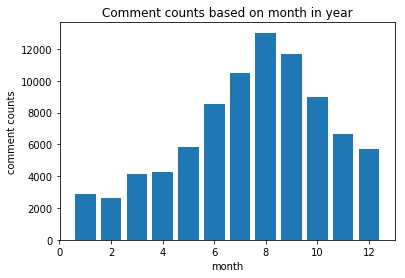

In [5]:
seattle_reviews['weekday'] = seattle_reviews['date'].map(lambda date_str: datetime.strptime(date_str, '%Y-%m-%d').weekday())
seattle_reviews['month'] = seattle_reviews['date'].map(lambda date_str: datetime.strptime(date_str, '%Y-%m-%d').month)

plt.bar(list(range(1, 13)), seattle_reviews.groupby('month').count()['comments'])
plt.title('Comment counts based on month in year')
plt.xlabel('month')
plt.ylabel('comment counts')
print()

From the figure above, we can see that most comments come from period July to September with August being the most popular. This also suggests the popular time Seattle is visited in the year.

**2. Listings **

In [6]:
seattle_listings.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [7]:
seattle_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

There are 3818 listings in the dataset with 92 columns. Some observations on the columns of the data:
1. Metadata column
    - id, name, host_id, host_name
2. Numeric columns
    - About host: host_listings_count, host_total_listings_count, host_response_rate (_stored as text for percentage_), host_acceptance_rate (_stored as text for percentage_)
    - About location: latitude, longitude
    - About listing: accommodates, bathrooms, bedrooms, beds, square_feet, guests_included (_number of guests allowed_), minimum_nights, maximum_nights, availability_30, availability_60, availability_90, availability_365, security_deposit (_stored as text, with dollar sign prefix_), cleaning_fee (_stored as text with dollar sign prefix_), extra_people (_fee for extra people, stored as text with dollar sign prefix_), calculated_host_listings_count
    - Review metrics: number_of_reviews, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, reviews_per_month
    - Price information: price, weekly_price, monthly_price
3. Text columns
    - listing description: summary, space, description, experiences_offered (_all entries are 'none'_), transit, host_location, host_about
4. Date columns:
    - host_since, first_review, last_review
5. Categorical columns:
    - About host: host_response_time, host_is_superhost, host_neighbourhood, host_has_profile_pic, host_identity_verified, host_verifications (_hold multiple categories_)
    - About location: neighbourhood, neighbourhood_cleansed, neighbourhood_group_cleansed, zipcode, smart_location, market, street, city, state, country, country_code, is_location_exact
    - About the listing: property_type, room_type, bed_type, amenities (_hold multiple categories_), has_availability, instant_bookable, cancellation_policy, require_guest_profile_picture, require_guest_phone_verification
6. Other columns (columns that are not useful for analysis): 
    - listing_url, scrape_id, last_scraped, notes, thumbnail_url, medium_url, picture_url, xl_picture_url, host_url, host_thumbnail_url, host_picture_url, calendar_updated, calendar_last_scraped, requires_license, license, jurisdiction_names


We will analyze some columns of interest:

In [8]:
def plot_hist(df, column):
    '''
    Plot histogram for a certain column in a dataframe
    
    :param dataframe df: dataframe from which the column is extracted  
    :param string column: the column to plot the histogram

    '''
    
    plt.hist(df[column].dropna())
    plt.title(column + ' histogram')
    plt.xlabel(column)
    plt.ylabel('count')
    print()

**price**

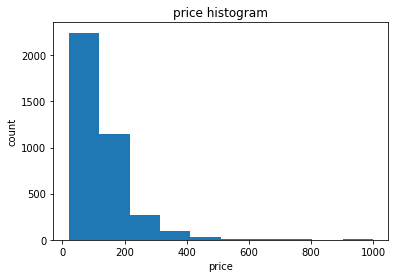

In [9]:
def convert_price_string(price_string):
    '''
    Convert the price string prefixed with dollar sign to number value
    
    :param string price_string: the string presentation of price to be converted
    :return float: the extracted float value in the string
    '''
    price_string = str(price_string)[1:] if str(price_string).startswith('$') else str(price_string)
    price_string = price_string.replace(',', '')
    return float(price_string)

seattle_listings['price'] = seattle_listings['price'].map(convert_price_string)
plot_hist(seattle_listings, 'price')

From the figure above, we can answer question 2: 

_What is the price range for renting AirBnB in Seattle?_

The price falls mostly under the under \$200 price range. However, we can see there are cases where the price can go up to \$1000. Tourists can adjust their needs for a room in Seattle during their visit

**room size: square_feet **

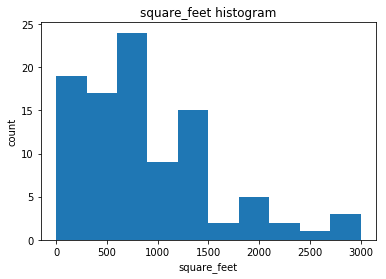

In [10]:
plot_hist(seattle_listings, 'square_feet')

From the figure above, we can see that room size is very diverse and there are a lot of different options for users to choose from

**review_scores_rating**

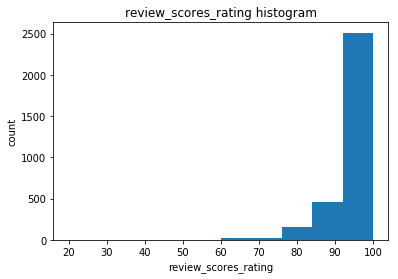

In [11]:
plot_hist(seattle_listings, 'review_scores_rating')

We can see that people rarely leaves a bad review rating, almost all rating is from 80% and above. This also shows the capability of AirBnB to maintain high standard for good service for the hosts.

**3. Calendar**

In [12]:
seattle_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [13]:
seattle_calendar.head(n=10)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN
5,241032,2016-01-09,f,NaN
6,241032,2016-01-10,f,NaN
7,241032,2016-01-11,f,NaN
8,241032,2016-01-12,f,NaN
9,241032,2016-01-13,t,$85.00


We will examine the relation between **avaialbe** and **price** columns

In [14]:
available_day_listing = seattle_calendar[seattle_calendar['available'] == 't']
none_price_listing = available_day_listing.isnull().sum()['price']
if none_price_listing:
    print('There exists some available listing with no price listed')
else:
    print('All available listinng has associated price')

All available listinng has associated price


In [15]:
unavailable_day_listing = seattle_calendar[seattle_calendar['available'] == 'f']
none_price_count = unavailable_day_listing.isnull().sum()['price']
if none_price_count == unavailable_day_listing.shape[0]:
    print('All unavailable listings do not have associated price')
else:
    print('There exists some unavailable listing with price')

All unavailable listings do not have associated price


In this dataset, if **available** column is true then the price will be available, else the **price** will be NaN

Next, we will examine the avaiability of rooms according to month

In [16]:
seattle_calendar['month'] = seattle_calendar['date'].map(lambda date_str: datetime.strptime(date_str, '%Y-%m-%d').month)
room_availability_by_month = seattle_calendar[seattle_calendar['available'] == 't']\
    .groupby(['month']).count()['listing_id']
room_availability_by_month

month
1     64937
2     73321
3     83938
4     76037
5     79971
6     77244
7     74222
8     76347
9     77246
10    82438
11    81780
12    87061
Name: listing_id, dtype: int64

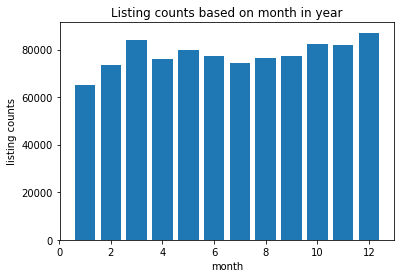

In [17]:
plt.bar(room_availability_by_month.index, room_availability_by_month)
plt.title('Listing counts based on month in year')
plt.xlabel('month')
plt.ylabel('listing counts')
print()

From the figure above, combined with the analysis on review count by month, we can answer the first question:

_What is the best time to visit Seattle based on the availability of rooms for rent on AirBnB?_

- The listing availablility is quite high thoughout the year with March and December being the most available and January is the least
- People may consider go to Seattle during July-September because there are high room availability on AirBnB. In addition, from the comments count above, we can deduce that there are a lot of comments for this period, hinting that this could be the popular time of the year to visit Seattle.

## Data Preparation <a class="anchor" id="Data-Preparation"></a>

In this section, we will clean the seattle_listings dataframe to prepare to price prediction as in question 3.

In [18]:
# drop unnecessary columns
columns_to_drop = [
    'id', 'name', 'host_id', 'host_name', # metadata columns
    'summary', 'space', 'description', 'experiences_offered', 'transit', 'host_location', 'host_about', # text columns
    'host_since', 'first_review', 'last_review', # date columns
    'neighborhood_overview', 'host_neighbourhood', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'zipcode', 'smart_location', 'market', 'street', 'city', 'state', 'country', 'country_code', 'is_location_exact', # there are atitude, longitude columns for location
    'listing_url', 'scrape_id', 'last_scraped', 'notes', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', # other columns
    'host_thumbnail_url', 'host_picture_url', 'calendar_updated', 'calendar_last_scraped', 'requires_license', # other columns
    'license', 'jurisdiction_names' # other columns
]
seattle_listings = seattle_listings.drop(columns_to_drop, axis=1)

In [19]:
# drop columns with lots of null values
print('Percentage of missing data in columns:')
null_percentage = seattle_listings.isnull().sum(axis=0) / seattle_listings.shape[0] * 100
null_percentage

Percentage of missing data in columns:


host_response_time                  13.698271
host_response_rate                  13.698271
host_acceptance_rate                20.246202
host_is_superhost                    0.052383
host_listings_count                  0.052383
host_total_listings_count            0.052383
host_verifications                   0.000000
host_has_profile_pic                 0.052383
host_identity_verified               0.052383
latitude                             0.000000
longitude                            0.000000
property_type                        0.026192
room_type                            0.000000
accommodates                         0.000000
bathrooms                            0.419068
bedrooms                             0.157150
beds                                 0.026192
bed_type                             0.000000
amenities                            0.000000
square_feet                         97.459403
price                                0.000000
weekly_price                      

From the missing data analysis above, we will drop columns with at least 25% missing data. For the remaining data, rows with missing data will be dropped

In [20]:
missing_data_columns = null_percentage[null_percentage > 25].index.tolist()
seattle_listings_drop_na = seattle_listings.drop(missing_data_columns, axis=1).dropna(axis=0)
seattle_listings_drop_na

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,latitude,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,within a few hours,96%,100%,f,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,47.636289,...,10.0,10.0,9.0,10.0,f,moderate,f,f,2,4.07
1,within an hour,98%,100%,t,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,47.639123,...,10.0,10.0,10.0,10.0,f,strict,t,t,6,1.48
2,within a few hours,67%,100%,f,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,47.629724,...,10.0,10.0,10.0,10.0,f,strict,f,f,2,1.15
6,within an hour,100%,100%,t,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,47.636605,...,10.0,10.0,10.0,10.0,f,moderate,f,f,1,2.46
7,within an hour,100%,100%,t,5.0,5.0,"['email', 'phone', 'facebook', 'google', 'link...",t,t,47.640161,...,10.0,10.0,9.0,10.0,f,strict,t,t,5,4.73
9,within an hour,98%,100%,t,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,47.637492,...,10.0,10.0,10.0,9.0,f,strict,t,t,6,1.55
10,within a few hours,100%,100%,t,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,47.635482,...,10.0,10.0,10.0,10.0,f,moderate,t,f,1,3.33
11,within a few hours,100%,100%,f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,47.637214,...,9.0,10.0,10.0,9.0,f,strict,f,f,1,0.98
12,within an hour,100%,100%,t,1.0,1.0,"['email', 'phone', 'linkedin', 'reviews', 'jum...",t,t,47.635546,...,10.0,10.0,10.0,10.0,f,moderate,f,f,1,0.92
13,within an hour,100%,100%,f,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,47.629507,...,9.0,9.0,10.0,10.0,f,strict,f,f,1,3.00


In [21]:
### process numeric columns stored as string

# process percentage
def convert_percentage_string(pct_string):
    '''
    Convert the percentage string prefixed with percentage sign to number value
    
    :param string pct_string: the string presentation of percentage to be converted
    :return float: the extracted float value in the string
    '''
    return float(pct_string.replace('%', '').strip())

for percentage_cols in ['host_response_rate', 'host_acceptance_rate']:
    seattle_listings_drop_na[percentage_cols] = seattle_listings_drop_na[percentage_cols].map(convert_percentage_string)

# process dollar sign column
seattle_listings_drop_na['extra_people'] = seattle_listings_drop_na['extra_people'].map(convert_price_string)

In [22]:
### process binary columns
# in those columns, values are store as 't' or 'f'
binary_columns = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification']
for col in binary_columns:
    seattle_listings_drop_na[col] = seattle_listings_drop_na[col].map(lambda value: value == 't')

In [23]:
### process category columns where each columns store multiple values

def find_value_lists(df, col):
    '''
    Extract values in categorical columns where each cell stored multiple as a list
    
    :param dataframe df: dataframe from which the column is extracted
    :param string col: column name of the column to be extracted for values
    :return list_of_string: list of individual values that appear in the column
    '''
    values = set([])
    stored_values = df[col]
    for stored_value in stored_values:
        stored_value = re.sub(r'[\'\"\[\]\{\}]', '', stored_value).split(',')
        for val in stored_value:
            if val.strip():
                values.add(val.strip())
    return list(values)


def extend_columns(df, col):
    '''
    Get dummies for categorical column with multile categories stored in a single cell
    
    :param dataframe df: dataframe from which the column is extracted
    :param string col: column name of the column to be extracted for values
    :return dataframe: a new dataframe with the col replaced by its category columns
    
    '''
    categories = find_value_lists(df, col)
    for cat in categories:
        df[col+ '_' + cat] = df[col].map(lambda val: cat in val)
    return df.drop([col], axis=1)

In [24]:
seattle_listings_drop_na = extend_columns(seattle_listings_drop_na, 'amenities')
seattle_listings_drop_na = extend_columns(seattle_listings_drop_na, 'host_verifications')

In [25]:
# get dummies for other columns
clean_data = pd.get_dummies(seattle_listings_drop_na)

In [26]:
clean_data

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,...,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,96.0,100.0,False,3.0,3.0,True,True,47.636289,-122.371025,4,...,0,0,0,0,0,0,1,0,1,0
1,98.0,100.0,True,6.0,6.0,True,True,47.639123,-122.365666,4,...,0,0,0,0,0,0,1,0,0,1
2,67.0,100.0,False,2.0,2.0,True,True,47.629724,-122.369483,11,...,0,0,0,0,0,0,1,0,0,1
6,100.0,100.0,True,1.0,1.0,True,True,47.636605,-122.368519,2,...,1,0,0,0,0,0,1,0,1,0
7,100.0,100.0,True,5.0,5.0,True,True,47.640161,-122.375856,2,...,1,0,0,0,0,0,1,0,0,1
9,98.0,100.0,True,6.0,6.0,True,True,47.637492,-122.366889,4,...,0,0,0,0,0,0,1,0,0,1
10,100.0,100.0,True,1.0,1.0,True,True,47.635482,-122.358478,2,...,0,0,0,0,0,0,1,0,1,0
11,100.0,100.0,False,1.0,1.0,True,True,47.637214,-122.360046,2,...,0,0,0,0,0,0,1,0,0,1
12,100.0,100.0,True,1.0,1.0,True,True,47.635546,-122.373171,4,...,0,0,0,0,0,0,1,0,1,0
13,100.0,100.0,False,1.0,1.0,True,True,47.629507,-122.367629,5,...,0,0,0,0,0,0,1,0,0,1


## Modeling and Evaluation <a class="anchor" id="Modeling"></a>

In this section, we will predict the price of AirBnB listing based on the preprocessed data above. We will use Linear Regression model for prediction

In [27]:
X, y = clean_data.drop(['price'], axis=1), clean_data[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale the train data before feeding to machine learning algorithm
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [32]:
def train_model(model, model_name):
    '''
    Train a machine learning model on the processed data
    
    :param model: machine model object from sklearn
    :param model_name: title of the model, used
    
    '''
    model.fit(X_train, y_train)
    y_pred = model.predict(scaler.transform(X_test))
    # The mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print("Model:", model_name)
    print("Mean squared error: %.2f"% mse)
    # Explained variance score: 1 is perfect prediction
    r2 = r2_score(y_test, y_pred)
    print('Variance score: %.2f' % r2)
    print('-----')
    return model_name, mse, r2

models = [
    (RandomForestRegressor(n_estimators=100, max_depth=5), 'Random Forest Regressor'),
    (LinearRegression(), 'Linear Regression'),
    (Lasso(alpha=0.1), 'Lasso Regression')
]
    
model_result = pd.DataFrame(columns=['Model', 'Mean squared error', 'R2 Score'])
for model in models:
    model_name, mse, r2 = train_model(*model)
    model_result = model_result.append({'Model': model_name, 'Mean squared error': mse, 'R2 Score': r2}, ignore_index=True)

model_result

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Model: Random Forest Regressor
Mean squared error: 2851.00
Variance score: 0.60
-----
Model: Linear Regression
Mean squared error: 1340058408951881949773824.00
Variance score: -188388058287845244928.00
-----
Model: Lasso Regression
Mean squared error: 2407.56
Variance score: 0.66
-----


,Model,Mean squared error,R2 Score
0,Random Forest Regressor,2.851004e+03,5.992003e-01
1,Linear Regression,1.340058e+24,-1.883881e+20
2,Lasso Regression,2.407561e+03,6.615403e-01


We can see that the results of the price prediction looks acceptable with relatively low variace score. In term of R2 Score, Random Forest Regressor returns best result. However, we can still improve because the number of records used for prediction is not enough, in comparision with the number of features we are having in the dataset. To get better result, actions we might consider to take are:

- Collect more data listings data or data from similar cities
- Reduce number of features in the dataset
- Re-evaluate the approach to predict the price as this task might not be reasonable. More relevant features might be analyzed and collected

## Deployment and Conclusion <a class="anchor" id="Deployment"></a>

From the analysis in this notebook, we can answer the questions stated at the beginnings:

**1. What is the best time to visit Seattle based on the availability of rooms for rent on AirBnB?**

- The listing availablility is quite high thoughout the year with March and December being the most available and January is the least
- People may consider go to Seattle during July-September because there are high room availability on AirBnB. In addition, from the comments count above, we can deduce that there are a lot of comments for this period, hinting that this could be the popular time of the year to visit Seattle.

** 2. What is the price range for renting AirBnB in Seattle? **

The price falls mostly under the under \$200 price range. However, we can see there are cases where the price can go up to $1000. Tourists can adjust their needs for a room in Seattle during their visit

** 3. How could we best predict the price for a listing? **
Random Forest Regressor is the best model for the task. The result can still be improved because the data is not collected enought. Actions to be taken to have a better model

- collect more data records for new listings
- reduce number of features in the dataset
- collect more reasonable attributes to add to the dataset